In [35]:
import numpy as np
from imutils.object_detection import non_max_suppression
import cv2
import pytesseract as pt
import matplotlib
import pandas as pd
from matplotlib import pyplot as plt

In [36]:
#reading image and resizing 
img=cv2.imread('sample/bills/dataset2/9.jpg')[10:650]
#east requires images sizes in multiples of 32
print(img.shape[0],img.shape[1])
y=int(img.shape[0]/32)*32
x=int(img.shape[1]/32)*32
img=cv2.resize(img,(x,y))
print(img.shape[0],img.shape[1])
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

640 2032
640 2016


In [37]:
#setting figure size of plots equal to image size
dpi = matplotlib.rcParams['figure.dpi']
figsize=img.shape[1]/dpi,img.shape[0]/dpi

In [38]:
#fn to convert east detection rotated bounding boxes to regular bounding boxes source:pyImageSearch 
def decode_predictions(scores, geometry,minConfidence):
	# grab the number of rows and columns from the scores volume, then
	# initialize our set of bounding box rectangles and corresponding
	# confidence scores
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []
 
	# loop over the number of rows
	for y in range(0, numRows):
		# extract the scores (probabilities), followed by the
		# geometrical data used to derive potential bounding box
		# coordinates that surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]
 
		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability,
			# ignore it
			if scoresData[x] < minConfidence:
				continue
 
			# compute the offset factor as our resulting feature
			# maps will be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)
 
			# extract the rotation angle for the prediction and
			# then compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)
 
			# use the geometry volume to derive the width and height
			# of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]
 
			# compute both the starting and ending (x, y)-coordinates
			# for the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)
 
			# add the bounding box coordinates and probability score
			# to our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])
 
	# return a tuple of the bounding boxes and associated confidences
	return (rects, confidences)

In [39]:
def returnContours(mask):
    cnts=cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
    rects=[cv2.boundingRect(cnt) for cnt in cnts]
    rects=np.array([[x,y,x+w,y+h] for x,y,w,h in rects])
    return rects

In [40]:
#drawing bouding boxes on image
def drawRects(rects,img):
    for x1,y1,x2,y2 in rects:
        cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),3)
    

In [41]:
#Text detection and getting bounding boxes
meanRGB=(123.68, 116.78, 103.94)
h,w=img.shape[:2]
blob=cv2.dnn.blobFromImage(img,1.0,(w,h),meanRGB,swapRB=True,crop=False)

layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
net=cv2.dnn.readNet('frozen_east_text_detection.pb')

net.setInput(blob)
scores,locs=net.forward(layerNames)

#getting bounding rects from east's output
rects,conf=decode_predictions(scores,locs,0.3)
rects=non_max_suppression(np.array(rects), probs=conf)

In [42]:
#generating mask of detected text
black=np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)
mask=black.copy()
for x1,y1,x2,y2 in rects:
    mask[max(0,y1):min(mask.shape[0],y2),max(0,x1):min(mask.shape[1],x2)]=255


In [43]:
#finding heading threshold

#discarding boxes extending outside image
discard=np.where(rects<0)
print(discard)
rects=np.delete(rects,discard,axis=0)

(array([], dtype=int64), array([], dtype=int64))


In [44]:
#merge text boxes to form batches
kernel=np.ones((60,1),np.uint8)
mask2=cv2.dilate(mask.copy(),kernel)

'''
fig=plt.figure(figsize=figsize)
plt.imshow(mask)
fig=plt.figure(figsize=figsize)
plt.imshow(mask2)
'''

'\nfig=plt.figure(figsize=figsize)\nplt.imshow(mask)\nfig=plt.figure(figsize=figsize)\nplt.imshow(mask2)\n'

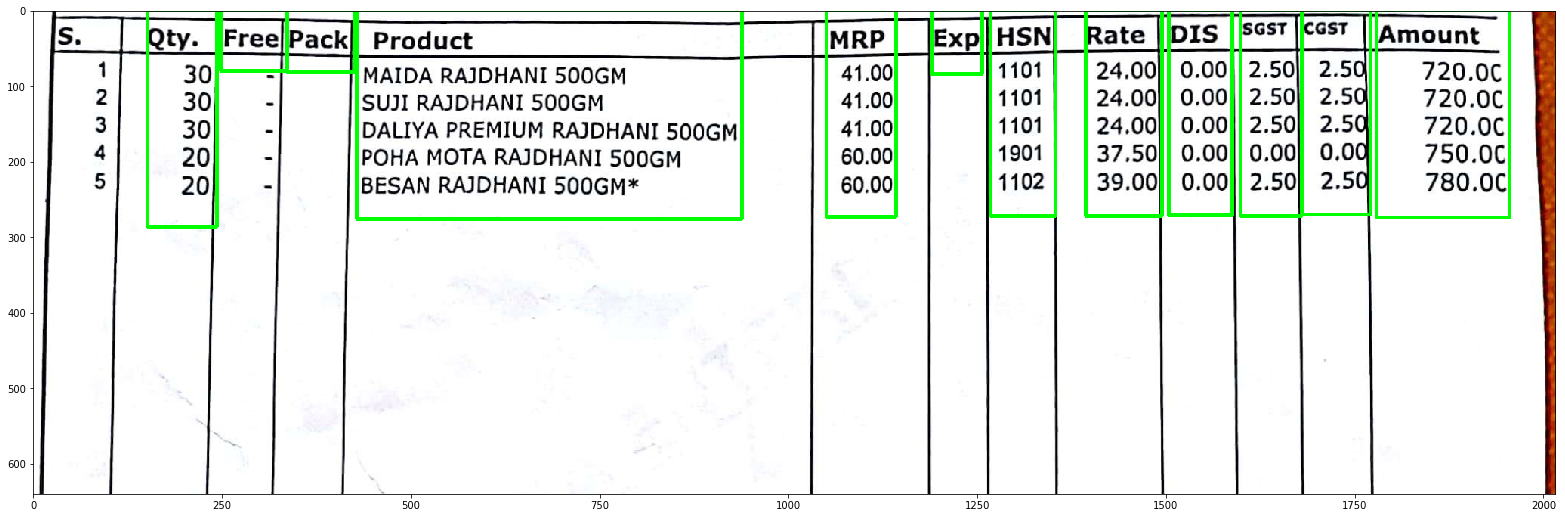

In [45]:
#find contours and boudingRects of batches and reject if boxes start midway.
batches=returnContours(mask2)
#avg_area=np.mean([w*h for x,y,w,h in batches])
batches=np.array([[max(0,x1-3),max(0,y1-2),min(img.shape[1],x2+3),min(img.shape[0],y2+3)] for x1,y1,x2,y2 in batches if y1<img.shape[0]/5])

#Reject serial number column, usually the first column on left. It will be replaced by indexes in dataframe
batches=batches[np.argsort(batches[:,0])][1:]

batchBox=img.copy()
drawRects(batches,batchBox)
fig=plt.figure(figsize=figsize)
plt.imshow(batchBox)

In [46]:
#recognize text in every batch
config='--psm 6'

texts=[]
for x1,y1,x2,y2 in batches:
        crop=img[y1:y2,x1:x2].copy()
        crop =cv2.GaussianBlur(crop,(3,3),0)
        text=pt.image_to_string(crop,lang='eng',config=config)
        text=[txt for txt in text.split('\n') if txt!='']
        texts.append(text)
        print(text)
        print('\n')
        print('\n')


['Qty.', '30', '30', '30', '20', '20']




['Free]']




['Pack']




['Product', 'MAIDA RAJDHANI 500GM', 'SUJI RAJDHANI SOOGM', 'DALIYA PREMIUM RAJDHANI 500GM', 'POHA MOTA RAJDHANI S500GM', 'BESAN RAJDHANI 500GM*']




['MRP', '41.00', '41.00', '41.00', '60.00', '60.00']




['Exp']




['HSN', '1101', '1101', '1101', '1901', '4102']




['Rate', '24.00', '24.00', '24.00)', '37.50', '39.00)']




['DIS', '0.00', '0.00', '0.00', '0.00', '0.00']




['SGST', '2.50)', '2.50', '2.50', '0.00', '2.50)']




['cGsT', '2.5', '2.5', '2.5)', '0.0', '2.5']




['Amount_', '720.0¢', '720.0C', '720.0C', '750.0C', '780.0C']






In [47]:
#Identify headings and data. Convert to dataframe and save to excel file
keys=[lis[0] for lis in texts]
keys
data={}
for i,key in enumerate(keys):
    data[key]=texts[i][1:]

df=pd.DataFrame({k : pd.Series(v) for k, v in data.items()})
df.index=np.arange(1,len(df)+1)
df.to_excel('bill_temp/table10.xlsx')
df

C:\Users\athar\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,Qty.,Free],Pack,Product,MRP,Exp,HSN,Rate,DIS,SGST,cGsT,Amount_
1,30,NaN,NaN,MAIDA RAJDHANI 500GM,41.00,NaN,1101,24.00,0.00,2.50),2.5,720.0¢
2,30,NaN,NaN,SUJI RAJDHANI SOOGM,41.00,NaN,1101,24.00,0.00,2.50,2.5,720.0C
3,30,NaN,NaN,DALIYA PREMIUM RAJDHANI 500GM,41.00,NaN,1101,24.00),0.00,2.50,2.5),720.0C
4,20,NaN,NaN,POHA MOTA RAJDHANI S500GM,60.00,NaN,1901,37.50,0.00,0.00,0.0,750.0C
5,20,NaN,NaN,BESAN RAJDHANI 500GM*,60.00,NaN,4102,39.00),0.00,2.50),2.5,780.0C
